In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import yfinance as yf
#from datetime import datetime, timedelta
import backtrader as bt
import quantstats
from collections import defaultdict
#Import my function library
import ipynb.fs.full.MRT_Funcs as MRT
#Import my strategy library
import ipynb.fs.full.BacktraderStrats as myStrats

//anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

<IPython.core.display.Javascript object>


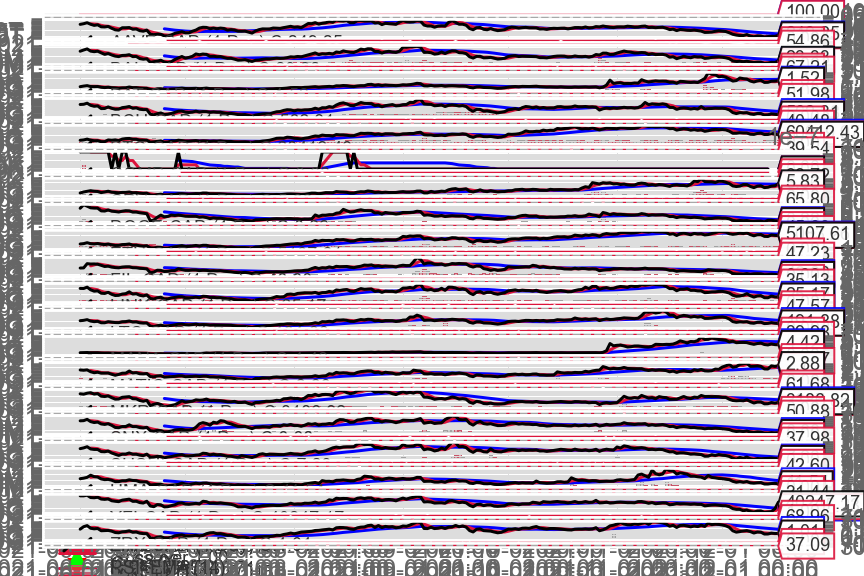

In [5]:
#Training set: cryptos valid back to 2018-01
tickers = ['ADA-CAD','BAT-CAD','BCH-CAD','BTC-CAD','DOGE-CAD','ETH-CAD','FIL-CAD','LINK-CAD','LTC-CAD','MANA-CAD','MKR-CAD','XTZ-CAD','XLM-CAD','ZRX-CAD']
#Cryptos not in the training set
#tickers = ['AAVE-CAD','BAL-CAD','COMP-CAD','CRV-CAD','KNC-CAD','MATIC-CAD','SNX-CAD','SUSHI-CAD','UMA-CAD','UNI3-CAD','YFI-CAD']
#All cryptos:
#tickers = ['AAVE-CAD','BAL-CAD','BAT-CAD','BCH-CAD','BTC-CAD','COMP-CAD','CRV-CAD','DOGE-CAD','ETH-CAD','FIL-CAD','LINK-CAD','LTC-CAD','MANA-CAD','MATIC-CAD','MKR-CAD','SNX-CAD','SUSHI-CAD','UMA-CAD','YFI-CAD','ZRX-CAD']
#Small dummy set:
#tickers = ['BTC-CAD','ETH-CAD','ADA-CAD']
#tickers = ['AMZN','GOOGL','AAPL','SNP','TSLA','RACE']

start_date = '2017-06-01'
end_date = '2021-01-01'

tearsheet=False
stats=False
plot=True
verbose=True

#Strategy parameters
wshort = 15
wlong = 45
shortlongthresh=0.05
wext=100
extthresh=0.25
SMA200_switch = True

#Instantiate Cerebro engine
cerebro = bt.Cerebro()

#Add data feed to Cerebro
MRT.addPortfolioToFeed(tickers, cerebro, start_date, end_date)

#Add strategy to Cerebro
#cerebro.addstrategy(myStrats.SMAdual_basic, wshort=wshort, wlong=wlong, shortlongthresh=shortlongthresh, wext=wext, extthresh=extthresh, sma200_switch=SMA200_switch, verbose=verbose)
cerebro.addstrategy(myStrats.RSI_MAcross, verbose=verbose)
#cerebro.addstrategy(myStrats.RSI, verbose=verbose)

#Set position size
cerebro.addsizer(bt.sizers.PercentSizer, percents = 20)

#Set broker cash initial value
cerebro.broker.set_cash(100) 

#Set broker commission rate
cerebro.broker.setcommission(commission=0.01)  # 1% of the operation value

#Add analyzers
if stats:
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = "sharpe")
    cerebro.addanalyzer(bt.analyzers.Returns, _name = "returns")
    cerebro.addanalyzer(bt.analyzers.Transactions, _name = "trans")
if tearsheet:
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

#cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = "sharpe")
#cerebro.addanalyzer(bt.analyzers.Returns,     _name = "returns")
#cerebro.addanalyzer(bt.analyzers.Transactions, _name = "trans")


if __name__ == '__main__':
    # Run Cerebro Engine
    start_portfolio_value = cerebro.broker.getvalue()

    results = cerebro.run()
    strat = results[0]

    end_portfolio_value = cerebro.broker.getvalue()
    pnl_strat = end_portfolio_value - start_portfolio_value
    print(f'Starting Portfolio Value: {start_portfolio_value:2f}')
    print(f'Final Portfolio Value: {end_portfolio_value:2f}')
    print(f'PnL: {pnl_strat:.2f}')
    
    if stats:
        print(results[0].analyzers.returns.get_analysis()['rnorm100'])
        print(results[0].analyzers.sharpe.get_analysis())
        print(results[0].analyzers.trans.get_analysis())
    
    if plot:
        cerebro.plot()
    
    if tearsheet:
        portfolio_stats = strat.analyzers.getbyname('PyFolio')
        returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
        returns.index = returns.index.tz_convert(None)
        quantstats.reports.html(returns, output='backtrader_tearsheets/stats.html', title='quantstats test')

## Buy & Hold Baseline

In [8]:
100/len(tickers)

7.142857142857143

In [11]:
tearsheet=False
plot=True
verbose=True

#Instantiate Cerebro engine
cerebro = bt.Cerebro()

#Add data feed to Cerebro
MRT.addPortfolioToFeed(tickers, cerebro, start_date, end_date)

#Add strategy to Cerebro
cerebro.addstrategy(myStrats.buy_hold, verbose=verbose)
#cerebro.addstrategy(myStrats.MaCrossStrategy)

#Set position size
fixed_percent = math.floor(100/len(tickers)) #Calculate percentage needed to split cash equally between the list of tickers
cerebro.addsizer(bt.sizers.PercentSizer, percents = fixed_percent)

#Set broker cash initial value
cerebro.broker.set_cash(100) 

#Set broker commission rate
cerebro.broker.setcommission(commission=0.01)  # 1% of the operation value

#Add analyzers
if tearsheet:
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

if __name__ == '__main__':
    # Run Cerebro Engine
    start_portfolio_value = cerebro.broker.getvalue()

    results = cerebro.run()
    strat = results[0]

    end_portfolio_value = cerebro.broker.getvalue()
    pnl_bh = end_portfolio_value - start_portfolio_value
    print(f'Starting Portfolio Value: {start_portfolio_value:2f}')
    print(f'Final Portfolio Value: {end_portfolio_value:2f}')
    print(f'PnL: {pnl_bh:.2f}')
    
    if plot:
        cerebro.plot()
    
    if tearsheet:
        portfolio_stats = strat.analyzers.getbyname('PyFolio')
        returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
        returns.index = returns.index.tz_convert(None)
        quantstats.reports.html(returns, output='backtrader_tearsheets/buyhold.html', title='quantstats test')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
2017-12-14 ADA-CAD BUY EXECUTED, 0

## Optimization

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Returns')

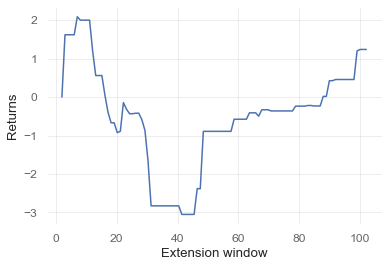

In [5]:
#Training set: cryptos valid back to 2018-01
#tickers = ['ADA-CAD','BAT-CAD','BCH-CAD','BTC-CAD','DOGE-CAD','ETH-CAD','FIL-CAD','LINK-CAD','LTC-CAD','MANA-CAD','MKR-CAD','XTZ-CAD','XLM-CAD','ZRX-CAD']
#Small dummy set:
tickers = ['BTC-CAD','ETH-CAD','ADA-CAD']

start_date = '2017-06-01'
end_date = '2021-01-01'

# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
#strats = cerebro.optstrategy(
    #myStrats.SMAdual_basic,
    #wshort=range(2, 35),
    #wlong=range(40, 100),
    #wext=range(2,100))
N=100
wexts = [2, 2+N]
wextv = np.linspace(wexts[0], wexts[1], N)
strats = cerebro.optstrategy(
    myStrats.SMAdual_basic,
    wext=range(wexts[0],wexts[1]))

#Add data feed
MRT.addPortfolioToFeed(tickers, cerebro, start_date, end_date)

#Add analyzer
cerebro.addanalyzer(bt.analyzers.Returns, _name = "returns")

# Set desired cash start
cerebro.broker.setcash(1000.0)

#Set position size
cerebro.addsizer(bt.sizers.PercentSizer, percents = 10)

# Set the commission
cerebro.broker.setcommission(commission=0.01)

# Run over everything
results = cerebro.run(maxcpus=1)

#Replace this with my optimization results plotting functions

#Store the returns from each gridpoint so I can plot the performance
returns = np.empty(N)
for i in range(0,N):
    returns[i] = results[i][0].analyzers.returns.get_analysis()['rnorm100']

plt.plot(wextv, returns)
plt.xlabel('Extension window')
plt.ylabel('Returns')